In [55]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



In [56]:
df_unlabeled = pd.read_pickle("../data/data_clean.pkl")
df_unlabeled = df_unlabeled[["contract","paragraph","section","section_content","clean_section_content"]]
display(df_unlabeled)

mapping = pd.read_excel("../data/mapping.xlsx")
mapping = mapping[["section_content","catalog_id"]]
display(mapping)

df_labeled = mapping.merge(df_unlabeled, how = "left", on = "section_content")
df_labeled= df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
display(df_labeled)

catalogue = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue["catalog_id"] = range(1, len(catalogue) + 1)
display(catalogue)

,contract,paragraph,section,section_content,clean_section_content
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,Der Anbieter stellt dem Kunden die Software Na...
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,Die Nutzung umfasst die Bereitstellung von Fun...
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,Der Kunde erhält ausschließlich das vertraglic...
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,1 Dieser SoftwareasaServiceVertrag ist auf On ...
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,2 Die Software wird vom Anbieter als webbasier...
...,...,...,...,...,...
1371,26,19.,19.2,"19.2 Anhänge sind in ihrer jeweils gültigen, d...",Anhänge sind in ihrer jeweils gültigen dh von ...
1372,26,19.,19.3,19.3 Nebenbestimmungen außerhalb dieses Vertra...,Nebenbestimmungen außerhalb dieses Vertrags un...
1373,26,19.,19.4,19.4 Die etwaige Unwirksamkeit einzelner Besti...,Die etwaige Unwirksamkeit einzelner Bestimmung...
1374,26,19.,19.5,19.5 Ergeben sich in der praktischen Infrastru...,Ergeben sich in der praktischen Infrastruktur ...


,section_content,catalog_id
0,(1) Zahlungszeitraum und Höhe der Vergütung ri...,7
1,(1) Der Kunde wird den Anbieter bei der Erbrin...,43
2,(3) Der Kunde verpflichtet sich in diesem Zusa...,48
3,"(1) Die Parteien sind verpflichtet, alle ihnen...",36
4,1.9. „Reaktionszeit“ bezeichnet die Zeit (z. B...,29
5,4.4. Während der Laufzeit hat der Auftraggeber...,57
6,4.1. Aufgrund dieses Vertrags dürfen die Parte...,36
7,8.1. Falls ein Dritter Ansprüche gegen Sie ode...,48
8,8.2. Wenn der Anbieter meint oder festgestellt...,48
9,8.3. Der Anbieter stellt den Empfänger nicht f...,48


,contract,paragraph,section,clean_section_content,catalog_id
0,2,§ 7,(1),1 Zahlungszeitraum und Höhe der richten sich ...,7
1,2,§ 8,(1),1 Der Kunde wird den Anbieter bei der Erbringu...,43
2,2,§ 11,(3),3 Der Kunde verpflichtet sich in diesem Zusamm...,48
3,2,§ 13,(1),1 Die Parteien sind verpflichtet alle ihnen im...,36
4,3,1.,1.9,19 „Reaktionszeit“ bezeichnet die Zeit z B in ...,29
...,...,...,...,...,...
62,25,§ 12,(3),3 Der Besteller kann Ersatz für die zum Zweck ...,65
63,25,§ 13,(3),3 Sofern wir fahrlässig eine vertragswesentlic...,63
64,25,§ 18,(3),3 Für alle Rechtsbeziehungen zwischen dem Best...,72
65,26,16.,16.2,Die außerordentliche Kündigung wegen oder im Z...,47


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,Im Festpreis von € sind sämtliche Leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,Der Kunde zahlt eine monatliche Pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,Die Vergütung ist in drei Raten zahlbar 30 bei...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",Alle Preise verstehen sich in Euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,Reise und Übernachtungskosten werden nur ersta...,5
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,Dieser Vertrag unterliegt dem Recht der Bundes...,72
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,Gerichtsstand für alle Streitigkeiten aus oder...,73
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",Dieser Vertrag wird in deutscher und englische...,74
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,Sollte eine Bestimmung dieses Vertrages unwirk...,75


In [57]:
# Pfad zum Modellordner
model_dir = "../models/raw_STM"

# Alle Modellpfade im Verzeichnis
model_paths = [os.path.join(model_dir, name) for name in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, name))]

# Dictionary: Name (bis 2. "_") → geladenes Modell
models_dict = {}

for path in model_paths:
    basename = os.path.basename(path)
    model_name_parts = basename.split("_")
    short_name = "_".join(model_name_parts[:2])  # z. B. base_bert
    models_dict[short_name] = SentenceTransformer(path)

# Namen und Modelle ausgeben
list(models_dict.keys())


['base_gbert', 'multilingual_paraphrase']

In [58]:
from tqdm import tqdm
import numpy as np

def embed_text_column(df, text_column, model, target_column, batch_size=16):
    """
    Berechnet SentenceTransformer-Embeddings spaltenweise (batchweise, CPU-optimiert).
    """
    texts = df[text_column].fillna("").tolist()
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Embedding {text_column}"):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            emb = model.encode(batch, convert_to_tensor=True)
        all_embeddings.extend(emb.cpu().numpy())

    df[target_column] = all_embeddings
    return df

Embedding example: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


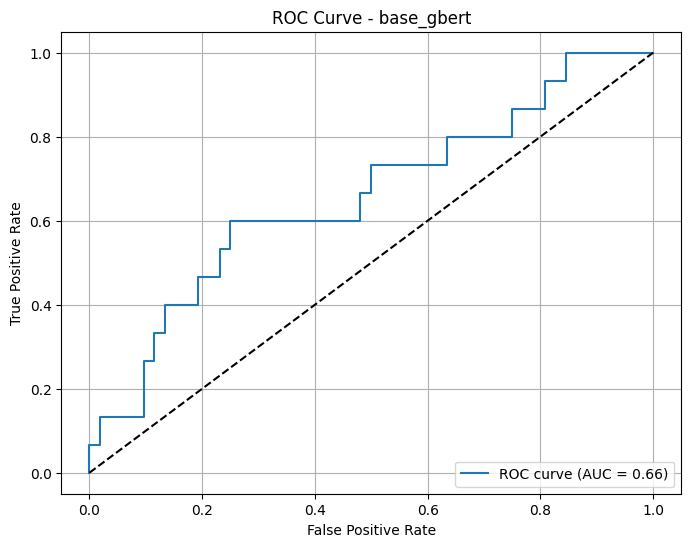

Optimaler Threshold für Cosine Similarity (%): 87.10


,contract,paragraph,section,clean_section_content,section_em_base_gbert,matched_example_index_base_gbert,similarity_percent_base_gbert,matched_example_text_base_gbert,matched_example_topic_base_gbert,matched_paragraph_base_gbert,matched_catalog_id_base_gbert,match_valid_base_gbert
0,2,§ 7,(1),1 Zahlungszeitraum und Höhe der richten sich ...,"[0.61777866, -0.21790117, -0.036513567, 0.5236...",26,84.250000,Mit der Abnahme der Gesamtleistung durch den K...,Werden die Folgen der Abnahme beschrieben (z.B...,Abnahmeprozesse,-99,False
1,2,§ 8,(1),1 Der Kunde wird den Anbieter bei der Erbringu...,"[-0.30595472, 0.4273497, -0.51387054, -0.29319...",22,86.570000,Der Kunde wird die vom Anbieter zur Abnahme ge...,"Hat der Kunde eine feste Frist, innerhalb dere...",Abnahmeprozesse,-99,False
2,2,§ 11,(3),3 Der Kunde verpflichtet sich in diesem Zusamm...,"[0.62840563, -0.4170676, -0.3101155, -0.016429...",56,86.930000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,-99,False
3,2,§ 13,(1),1 Die Parteien sind verpflichtet alle ihnen im...,"[0.5094682, 0.47420394, -0.19018483, -0.611065...",35,83.750000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,-99,False
4,3,1.,1.9,19 „Reaktionszeit“ bezeichnet die Zeit z B in ...,"[0.947709, -1.0561903, -0.05666527, -1.1468599...",23,79.180000,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,-99,False
...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),3 Der Besteller kann Ersatz für die zum Zweck ...,"[1.2706614, 0.1439868, 0.7337604, 0.3476024, 0...",64,85.510002,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,-99,False
63,25,§ 13,(3),3 Sofern wir fahrlässig eine vertragswesentlic...,"[0.17912976, 0.10399534, 0.2654392, -0.1592700...",70,86.000000,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,-99,False
64,25,§ 18,(3),3 Für alle Rechtsbeziehungen zwischen dem Best...,"[0.16866508, 1.0689102, 0.071905956, 0.0209517...",61,81.440002,Der Anbieter haftet nicht für indirekte Schäde...,Sind bestimmte Schäden von der Haftung ausgesc...,Haftung_und_Gewährleistung,-99,False
65,26,16.,16.2,Die außerordentliche Kündigung wegen oder im Z...,"[0.9969565, 1.1107272, -0.13331777, -0.7219183...",47,83.629997,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,-99,False


Embedding example: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


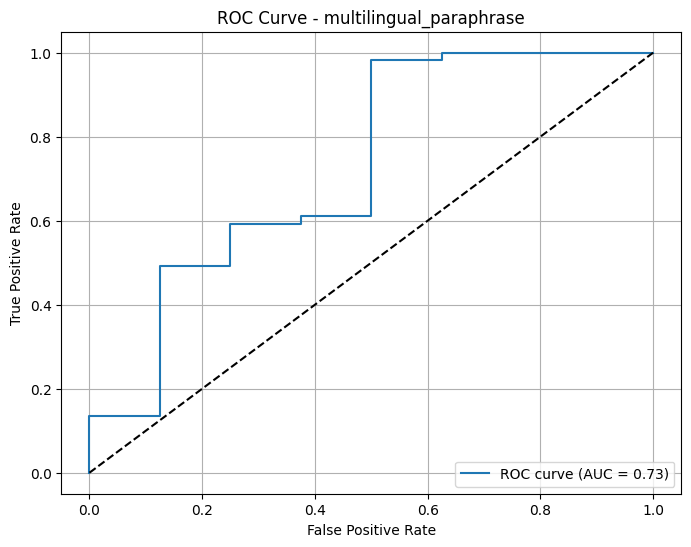

Optimaler Threshold für Cosine Similarity (%): 70.57


,contract,paragraph,section,clean_section_content,section_em_base_gbert,matched_example_index_base_gbert,similarity_percent_base_gbert,matched_example_text_base_gbert,matched_example_topic_base_gbert,matched_paragraph_base_gbert,matched_catalog_id_base_gbert,match_valid_base_gbert,section_em_multilingual_paraphrase,matched_example_index_multilingual_paraphrase,similarity_percent_multilingual_paraphrase,matched_example_text_multilingual_paraphrase,matched_example_topic_multilingual_paraphrase,matched_paragraph_multilingual_paraphrase,matched_catalog_id_multilingual_paraphrase,match_valid_multilingual_paraphrase
0,2,§ 7,(1),1 Zahlungszeitraum und Höhe der richten sich ...,"[0.61777866, -0.21790117, -0.036513567, 0.5236...",26,84.250000,Mit der Abnahme der Gesamtleistung durch den K...,Werden die Folgen der Abnahme beschrieben (z.B...,Abnahmeprozesse,-99,False,"[0.10155207, 0.25620925, -0.02808409, 0.018522...",6,78.269997,Die Parteien vereinbaren ein Höchstbudget von ...,Ist ein Gesamtbudget oder eine Preisobergrenze...,Projektkosten_und_Zahlungsmodalitäten,7,True
1,2,§ 8,(1),1 Der Kunde wird den Anbieter bei der Erbringu...,"[-0.30595472, 0.4273497, -0.51387054, -0.29319...",22,86.570000,Der Kunde wird die vom Anbieter zur Abnahme ge...,"Hat der Kunde eine feste Frist, innerhalb dere...",Abnahmeprozesse,-99,False,"[0.14142257, -0.16227815, -0.14575183, -0.2284...",42,83.040001,Der Anbieter führt die vereinbarten Leistungen...,Sind die Pflichten des Anbieters und der Leist...,Rechte_und_Pflichten_der_Vertragsparteien,43,True
2,2,§ 11,(3),3 Der Kunde verpflichtet sich in diesem Zusamm...,"[0.62840563, -0.4170676, -0.3101155, -0.016429...",56,86.930000,Bei Beendigung des Vertrages stellt der Anbiet...,"Ist zugesichert, dass der Kunde bei Vertragsen...",Exit-Strategien_und_Datenportabilität,-99,False,"[0.21370699, 0.11613475, -0.23000395, -0.23034...",47,90.120003,Der Anbieter stellt den Kunden von allen Forde...,"Enthält der Vertrag eine Klausel, die den Kund...",Rechte_und_Pflichten_der_Vertragsparteien,48,True
3,2,§ 13,(1),1 Die Parteien sind verpflichtet alle ihnen im...,"[0.5094682, 0.47420394, -0.19018483, -0.611065...",35,83.750000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,-99,False,"[0.15419579, 0.1425327, -0.5460638, -0.2504954...",35,92.070000,Die Parteien verpflichten sich alle ihnen im R...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit,36,True
4,3,1.,1.9,19 „Reaktionszeit“ bezeichnet die Zeit z B in ...,"[0.947709, -1.0561903, -0.05666527, -1.1468599...",23,79.180000,Die Implementierung jeder Modulgruppe wird vom...,Sind für einzelne Projektphasen oder -module T...,Abnahmeprozesse,-99,False,"[0.3558678, -0.32448867, 0.08978418, -0.217721...",28,74.309998,Supportfälle werden wie folgt priorisiert Krit...,Sind Reaktions- und Lösungszeiten für Supportf...,Service-Level-Agreements_(SLAs),29,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,25,§ 12,(3),3 Der Besteller kann Ersatz für die zum Zweck ...,"[1.2706614, 0.1439868, 0.7337604, 0.3476024, 0...",64,85.510002,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,-99,False,"[0.13215925, -0.014048405, 0.014433099, -0.050...",64,84.120003,Treten während der Gewährleistungsfrist Mängel...,Sind die Rechte des Kunden im Gewährleistungsf...,Haftung_und_Gewährleistung,65,True
63,25,§ 13,(3),3 Sofern wir fahrlässig eine vertragswesentlic...,"[0.17912976, 0.10399534, 0.2654392, -0.1592700...",70,86.000000,Eine Übertragung von Rechten und Pflichten aus...,"Ist eine Klausel enthalten, die die Übertragun...",Vertragslaufzeit_und_Kündigung,-99,False,"[-0.05530422, -0.020622581, -0.04406088, -0.06...",62,82.220001,Die vorstehenden Haftungsbeschränkungen gelten...,"Ist festgelegt, dass gewisse Fälle von der Haf...",Haftung_und_Gewährl

In [75]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
df_to_match = df_labeled[["contract","paragraph","section","clean_section_content"]]
df_true_match = df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
df_true_match.rename(columns={"catalog_id": "true_catalog_id"},inplace= True)
cols = ["contract","paragraph","section","clean_section_content"]

for model_name in models_dict:
    model_selected = models_dict[model_name]
    df_to_match = embed_text_column(df_to_match, text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}" )
    cat = embed_text_column(catalogue, text_column = "example", model = model_selected, target_column = "emb")
    cols.append(f"section_em_{model_name}")
    df_to_match  = df_to_match[cols]
    X = np.vstack(df_to_match[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
    Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

    # Cosine Similarity: alle Kombinationen
    similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
    similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Ergebnisse anhängen
    df_to_match[f"matched_example_index_{model_name}"] = best_match_idx
    df_to_match[f"similarity_percent_{model_name}"] = best_match_score
    df_to_match[f"matched_example_text_{model_name}"] = cat.loc[best_match_idx, "example"].values
    df_to_match[f"matched_example_topic_{model_name}"] = cat.loc[best_match_idx, "section_topic"].values
    df_to_match[f"matched_paragraph_{model_name}"] = cat.loc[best_match_idx, "paragraph_topic"].values
    df_to_match[f"matched_catalog_id_{model_name}"] = cat.loc[best_match_idx, "catalog_id"].values
    

    y_true = (df_true_match["true_catalog_id"].values == df_to_match[f"matched_catalog_id_{model_name}"].values).astype(int)
    y_scores = df_to_match[f"similarity_percent_{model_name}"].values / 100  # zurück zu 0–1

    # ROC-Kurve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    # Optimaler Threshold = max(tpr - fpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimaler Threshold für Cosine Similarity (%): {optimal_threshold * 100:.2f}")
    # Neue Spalte: Match nur wenn Score >= Threshold
    df_to_match[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
    df_to_match.loc[~df_to_match[f"match_valid_{model_name}"], f"matched_catalog_id_{model_name}"] = -99
    cols = list(df_to_match.columns)
    display(df_to_match)










In [82]:
df_matched = df_to_match
from sklearn.metrics import accuracy_score, f1_score, classification_report

for model_name in models_dict:
    print(f"### {model_name} ###")
    df_matched_ids = df_matched[["contract","paragraph","section","clean_section_content",f"matched_catalog_id_{model_name}"]]
    print("Accuracy:", accuracy_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))
    print("F1 (macro):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'))
    print("F1 (weighted):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted'))
    print("\nReport:\n", classification_report(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))

    print(f"### {model_name} ###")

### base_gbert ###
Accuracy: 0.13432835820895522
F1 (macro): 0.13427318295739346
F1 (weighted): 0.13777540867093105

Report:
               precision    recall  f1-score   support

         -99       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         5
           8       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         2
          30       0.00      0.00      0.00         2
          32       0.00      0.00      0.00         1
          34       0.00      0.00      0.00         1
         

/Users/dave/Desktop/05_NLP/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,
/Users/dave/Desktop/05_NLP/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  The class to report if `average='binary'` and the data is binary,
/Users/dave/Desktop/05_NLP/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  The class

[-99  71  66  62  49  51  67  75  47  36  73  58   8  54]


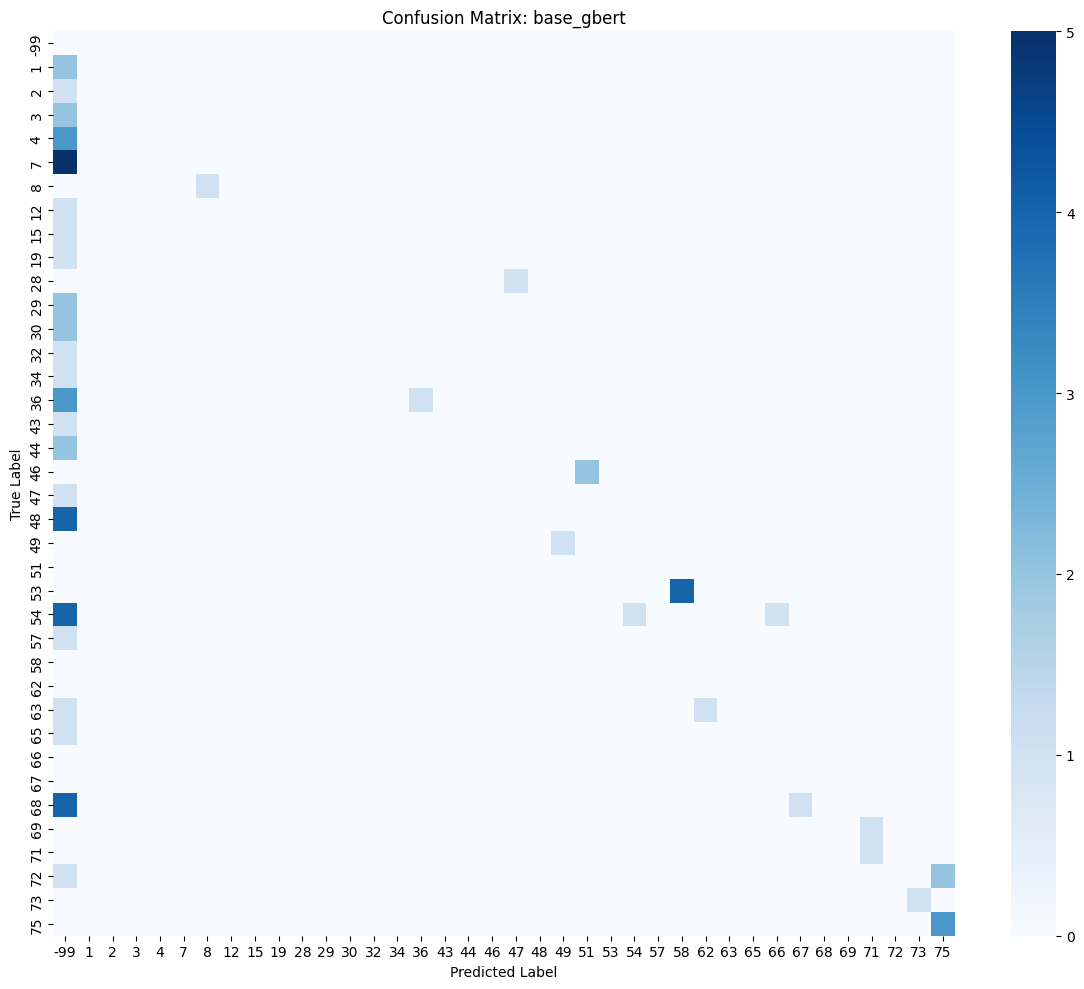

[  7  43  48  36  29 -99  68  70  54  32  63  19  71  49  46  75  72  73
  53   2  31  34   4  30   1   3  44  12   8  65  69]


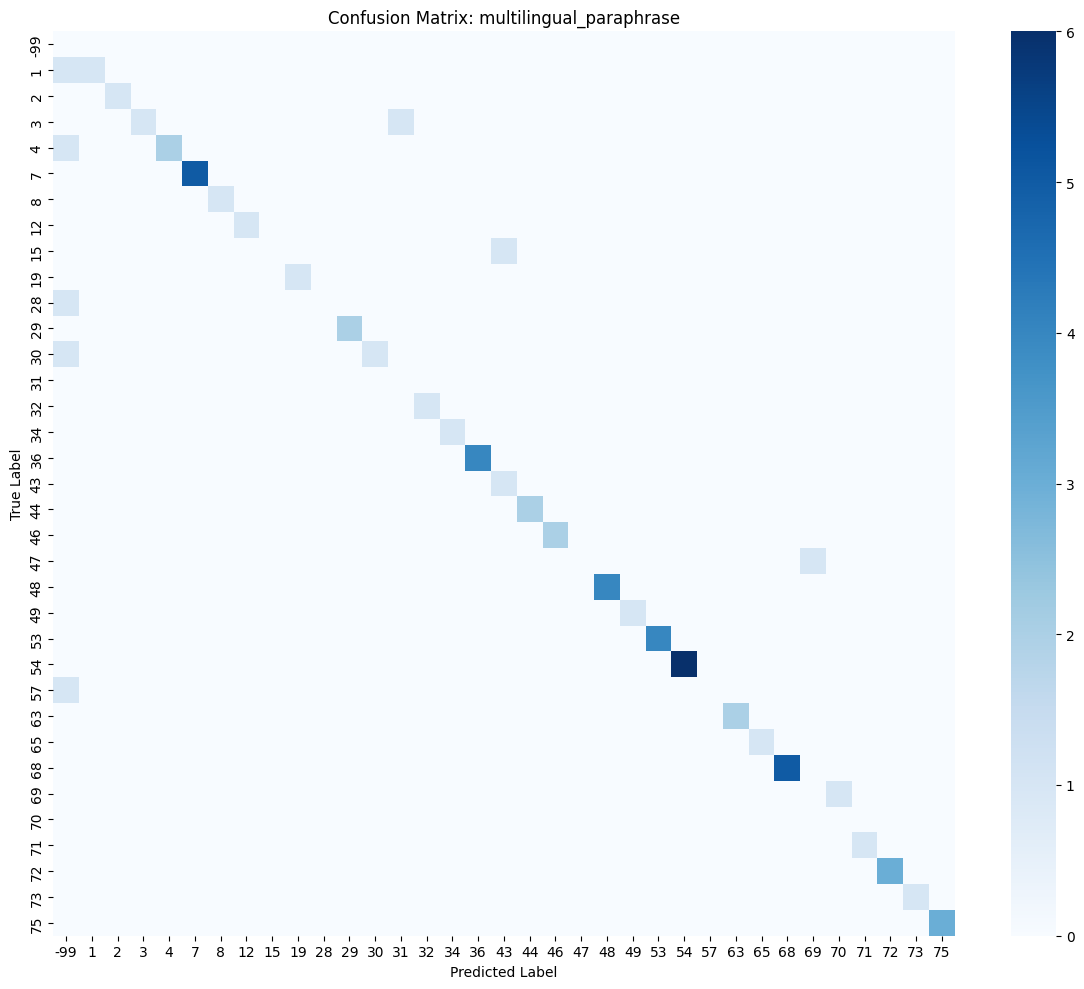

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
for model_name in models_dict:
    # Für bessere Lesbarkeit als np.array
    df_matched_ids = df_matched[["contract","paragraph","section","clean_section_content",f"matched_catalog_id_{model_name}"]]
    y_true = df_true_match["true_catalog_id"]
    y_pred = df_matched_ids[f"matched_catalog_id_{model_name}"]
    print(df_matched_ids[f"matched_catalog_id_{model_name}"].unique())
    # Confusion Matrix berechnen
    all_labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", 
                xticklabels=all_labels, 
                yticklabels=all_labels)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
